# ☘️ PLANT DISEASE CLASSIFICATION USING Custom CNN ☘️

# Description of the dataset 📝

# Our goal 🎯
Goal is clear and simple. We need to build a model, which can classify between healthy and diseased crop leaves and also if the crop have any disease, predict which disease is it.

##### Let's get started....

## Importing necessary libraries

Let's import required modules

We would require torchsummary library to print the model's summary in keras style (nicely formatted and pretty to look) as Pytorch natively doesn't support that

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchsummary import summary
import json
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import random
import platform
import contextlib
import io

# This is a Jupyter magic command to display plots inline
%matplotlib inline

# 🧭 Exploring the data 🧭

Loading the data 

In [2]:
DATA_DIR = "./new_data"
train_dir = DATA_DIR + "/train"
valid_dir = DATA_DIR + "/val"
test_dir = DATA_DIR + "/test"
diseases = os.listdir(train_dir)

In [3]:
# printing the disease names
print(diseases)

['Rice___tungro', 'Soybean__bacterial_blight', 'Tea__bird_eye_spot', 'Bell_pepper___bacterial_spot', 'Sugarcane__bacterial_blight', 'Apple___scab', 'Cassava___green_mottle', 'Jamun__healthy', 'Apple___healthy', 'Soybean__diabrotica_speciosa', 'Pomegranate__diseased', 'Rose___healthy', 'Tomato___late_blight', 'Tomato__yellow_leaf_curl_virus', 'Potato___early_blight', 'Chili__leaf curl', 'Wheat__septoria', 'Tea__brown_blight', 'Rice___bacterial_blight', 'Sugarcane__red_stripe', 'Potato___healthy', 'Pepper_bell__healthy', 'Tomato___mosaic_virus', 'Soybean__mosaic_virus', 'Coffee___rust', 'Coffee__cercospora_leaf_spot', 'Gauva__diseased', 'Mango__healthy', 'Strawberry___healthy', 'Potato___phytophthora', 'Wheat__brown_rust', 'Tomato___leaf_mold', 'Wheat__healthy', 'Rose___rust', 'Bell_pepper___healthy', 'Soybean__southern_blight', 'Peach___healthy', 'Cherry___powdery_mildew', 'Grape___black_measles', 'Tomato___leaf_curl', 'Potato___nematode', 'Pepper_bell__bacterial_spot', 'Rose___slug_saw

In [4]:
print("Total disease classes are: {}".format(len(diseases)))


Total disease classes are: 115


In [5]:
MODEL_NAME = "SOTA_CustomCNN"


# increase this as classes increases
NUM_CLASSES = 115


NUM_WORKERS = 8

CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
RESULTS_DIR = f"./results/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)



In [6]:
REAL_BATCH_SIZE = 16 

# The desired effective batch size for stable gradients
VIRTUAL_BATCH_SIZE = 64 

# Calculate the number of accumulation steps needed
# This ensures VIRTUAL_BATCH_SIZE is a multiple of REAL_BATCH_SIZE
assert VIRTUAL_BATCH_SIZE % REAL_BATCH_SIZE == 0, "Virtual batch size must be a multiple of real batch size!"
accumulation_steps = VIRTUAL_BATCH_SIZE // REAL_BATCH_SIZE

# Set the dataloader's batch size to the REAL batch size
# BATCH_SIZE = REAL_BATCH_SIZE


BATCH_SIZE_PHASE1 = 192
BATCH_SIZE_PHASE2 = 96


IMAGE_SIZE_PHASE1 = 192
IMAGE_SIZE_PHASE2 = 256

NUM_EPOCHS_PHASE1 = 20 
NUM_EPOCHS_PHASE2 = 25

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Sanity Check ---
print(f"Number of classes set to: {NUM_CLASSES} (Type: {type(NUM_CLASSES)})")
print(f"Using device: {device}")

Number of classes set to: 115 (Type: <class 'int'>)
Using device: cuda


In [8]:
# Initialize TensorBoard writer
writer = SummaryWriter(f'runs/{MODEL_NAME}')

The above cell extract the number of unique plants and number of unique diseases

In [9]:
plants = []
NumberOfDiseases = 0
for plant in diseases:
    if plant.split('__')[0] not in plants:
        plants.append(plant.split('__')[0])
    if plant.split('__')[1] != 'healthy':
        NumberOfDiseases += 1

In [10]:
# unique plants in the dataset
print(f"Unique Plants are: \n{plants}")

Unique Plants are: 
['Rice', 'Soybean', 'Tea', 'Bell_pepper', 'Sugarcane', 'Apple', 'Cassava', 'Jamun', 'Pomegranate', 'Rose', 'Tomato', 'Potato', 'Chili', 'Wheat', 'Pepper_bell', 'Coffee', 'Gauva', 'Mango', 'Strawberry', 'Peach', 'Cherry', 'Grape', 'Lemon', 'Corn', 'Sugercane', 'Blueberry', 'Watermelon', 'Squash', 'Orange', 'Raspberry', 'Cucumber']


In [11]:
# number of unique plants
print("Number of plants: {}".format(len(plants)))

Number of plants: 31


In [12]:
# number of unique diseases
print("Number of diseases: {}".format(NumberOfDiseases))

Number of diseases: 103


In [13]:
CHECKPOINT_DIR = f"./models/{MODEL_NAME}"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

So we have images of leaves of 14 plants and while excluding healthy leaves, we have 26 types of images that show a particular disease in a particular plant.

In [14]:
# Number of images for each disease
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
    
# converting the nums dictionary to pandas dataframe passing index as plant name and number of images as column

img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Rice___tungro,1046
Soybean__bacterial_blight,44
Tea__bird_eye_spot,240
Bell_pepper___bacterial_spot,797
Sugarcane__bacterial_blight,80
...,...
Rice__neck_blast,800
Chili__yellowish,80
Gauva__healthy,221
Apple___gray_spot,316


#### Visualizing the above information on a graph

In [15]:
# plotting number of images available for each disease
index = [n for n in range(NUM_CLASSES)]
plt.figure(figsize=(20, 5))
plt.bar(index, [n for n in nums.values()], width=0.3)
plt.xlabel('Plants/Diseases', fontsize=10)
plt.ylabel('No of images available', fontsize=10)
plt.xticks(index, diseases, fontsize=5, rotation=90)
plt.title('Images per each class of plant disease')

Text(0.5, 1.0, 'Images per each class of plant disease')

We can see that the dataset is almost balanced for all classes, so we are good to go forward

#### Images available for training

In [16]:
n_train = 0
for value in nums.values():
    n_train += value
print(f"There are {n_train} images for training")

There are 113451 images for training


In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
print(f"PyTorch Version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch Version: 2.8.0+cu128
CUDA Version: 12.8
GPU: NVIDIA L4


# 🍳 Data Preparation for training 🍳

In [18]:
data_transforms_phase1 = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE_PHASE1),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE_PHASE1 + 32),
        transforms.CenterCrop(IMAGE_SIZE_PHASE1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
print("Loading data with STRONGER augmentations...")
image_datasets_phase1 = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms_phase1[x]) for x in ['train', 'val']}

dataset_sizes_phase1 = {x: len(image_datasets_phase1[x]) for x in ['train', 'val']}
class_names_phase1 = image_datasets_phase1['train'].classes
print(f"Dataset sizes: Train={dataset_sizes_phase1['train']}, Val={dataset_sizes_phase1['val']}")

Loading data with STRONGER augmentations...
Dataset sizes: Train=113451, Val=14118


In [19]:
with open(os.path.join(RESULTS_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names_phase1, f)
print(f"Phase 1 DataLoaders created. Class names saved.")

Phase 1 DataLoaders created. Class names saved.


*A "Good and Complex" Custom CNN Model Definition*

In [20]:
import torch
import torch.nn as nn
from torchvision.ops import StochasticDepth

# --- CBAM: The Advanced Attention Module (Channel + Spatial) ---
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        # Use 1x1 convolutions as a shared MLP
        self.fc = nn.Sequential(nn.Conv2d(in_planes, in_planes // ratio, 1, bias=False),
                               nn.SiLU(),
                               nn.Conv2d(in_planes // ratio, in_planes, 1, bias=False))
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_planes, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.ca = ChannelAttention(in_planes, ratio)
        self.sa = SpatialAttention(kernel_size)

    def forward(self, x):
        # Apply channel attention, then spatial attention
        x = self.ca(x) * x
        x = self.sa(x) * x
        return x

# --- The SOTA Residual Block ---
class SOTA_ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, sd_prob=0.0):
        super(SOTA_ResidualBlock, self).__init__()
        self.silu = nn.SiLU(inplace=True)
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.cbam = CBAM(out_channels)
        self.stochastic_depth = StochasticDepth(sd_prob, "row")

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.shortcut(x) # Get the shortcut connection first

        out = self.silu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.cbam(out)
        
        # Apply stochastic depth to the main path
        out = self.stochastic_depth(out)
        
        # Add the identity and apply the final activation
        out += identity
        out = self.silu(out)
        return out

class SOTA_CustomCNN(nn.Module):
    def __init__(self, block, num_blocks, num_classes=116, sd_probs=None):
        super(SOTA_CustomCNN, self).__init__()
        self.in_channels = 64
        if sd_probs is None:
            sd_probs = [0.0] * 4

        self.stem = nn.Sequential(
            nn.Conv2d(3, self.in_channels // 2, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(self.in_channels // 2),
            nn.SiLU(inplace=True),
            nn.Conv2d(self.in_channels // 2, self.in_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(self.in_channels),
            nn.SiLU(inplace=True)
        )
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1, sd_prob=sd_probs[0])
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2, sd_prob=sd_probs[1])
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2, sd_prob=sd_probs[2])
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2, sd_prob=sd_probs[3])
        
        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.SiLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )

    def _make_layer(self, block, out_channels, num_blocks, stride, sd_prob):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for s in strides:
            layers.append(block(self.in_channels, out_channels, s, sd_prob=sd_prob))
            self.in_channels = out_channels
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.stem(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avg_pool(out)
        out = self.classifier(out)
        return out

# --- Instantiate the SOTA model ---
# Create a linear schedule for the stochastic depth probabilities.
# Deeper layers are more likely to be dropped, which is a common and effective practice.
# --- Instantiate the SOTA model ---
sd_probs = [x.item() for x in torch.linspace(0, 0.1, 4)]
# ✨ Use the new, clear class name ✨
model = SOTA_CustomCNN(SOTA_ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES, sd_probs=sd_probs)

print("\n--- Attempting Model Compilation ---")
if int(torch.__version__.split('.')[0]) >= 2:
    if platform.system() == "Windows":
        print("Windows OS detected. Skipping torch.compile() due to known issues.")
    else:
        print(f"{platform.system()} OS detected. Attempting to compile the model...")
        try:
            model = torch.compile(model)
            print("Model compiled successfully!")
        except Exception as e:
            print(f"Model compilation failed: {e}. Continuing without compilation.")
else:
    print(f"PyTorch version {torch.__version__} is less than 2.0. Skipping torch.compile.")



print(f"--- Model Summary for {MODEL_NAME} (before compilation) ---")
summary_str = io.StringIO()
with contextlib.redirect_stdout(summary_str):
    summary(model, input_size=(3, IMAGE_SIZE_PHASE2, IMAGE_SIZE_PHASE2), device="cpu") # Use CPU for summary
model_summary = summary_str.getvalue()
with open(os.path.join(RESULTS_DIR, "model_summary.txt"), "w") as f:
    f.write(model_summary)
print("Model summary saved to model_summary.txt")
print("-" * 70)



# --- Move the model to the GPU ---
model = model.to(device)
print(f"Model moved to {device}.")


--- Attempting Model Compilation ---
Linux OS detected. Attempting to compile the model...
Model compiled successfully!
--- Model Summary for SOTA_CustomCNN (before compilation) ---
Model summary saved to model_summary.txt
----------------------------------------------------------------------
Model moved to cuda.


In [21]:
print("\n--- Creating a WeightedRandomSampler to handle data imbalance ---")

# Get the count of images in each class for the training set
class_counts = np.array([0] * len(image_datasets_phase1['train'].classes))
for _, label in image_datasets_phase1['train'].samples:
    class_counts[label] += 1

# Calculate weights for each sample (not each class)
# weight = 1 / (number of samples in that sample's class)
sample_weights = [0] * len(image_datasets_phase1['train'])
for i, (image_path, label) in enumerate(image_datasets_phase1['train'].samples):
    class_weight = 1. / class_counts[label]
    sample_weights[i] = class_weight

# Create the sampler
sampler = torch.utils.data.WeightedRandomSampler(
    weights=torch.DoubleTensor(sample_weights),
    num_samples=len(image_datasets_phase1['train']),
    replacement=True
)

print("WeightedRandomSampler created successfully.")


--- Creating a WeightedRandomSampler to handle data imbalance ---
WeightedRandomSampler created successfully.


In [22]:
dataloaders_phase1 = {
    'train': DataLoader(image_datasets_phase1['train'], batch_size=BATCH_SIZE_PHASE1, 
                        sampler=sampler, num_workers=NUM_WORKERS, pin_memory=True), # Use sampler, shuffle=False
    'val': DataLoader(image_datasets_phase1['val'], batch_size=BATCH_SIZE_PHASE1, 
                      shuffle=False, num_workers=NUM_WORKERS, pin_memory=True) # Val should not be shuffled
}

In [23]:
def plot_lr_finder_save(lr_finder, save_path):
    lr_finder.plot()
    plt.savefig(save_path)
    print(f"LR Finder plot saved to {save_path}")
    plt.close()

# 🏗️ Modelling 🏗️

It is advisable to use GPU instead of CPU when dealing with images dataset because CPUs are generalized for general purpose and GPUs are optimized for training deep learning models as they can process multiple computations simultaneously. They have a large number of cores, which allows for better computation of multiple parallel processes. Additionally, computations in deep learning need to handle huge amounts of data — this makes a GPU’s memory bandwidth most suitable.
To seamlessly use a GPU, if one is available, we define a couple of helper functions (`get_default_device` & `to_device`) and a helper class `DeviceDataLoader` to move our model & data to the GPU as required


--- Finding Optimal LR for a batch size of 192 ---


/home/ayyappa/anaconda3/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.30E-03


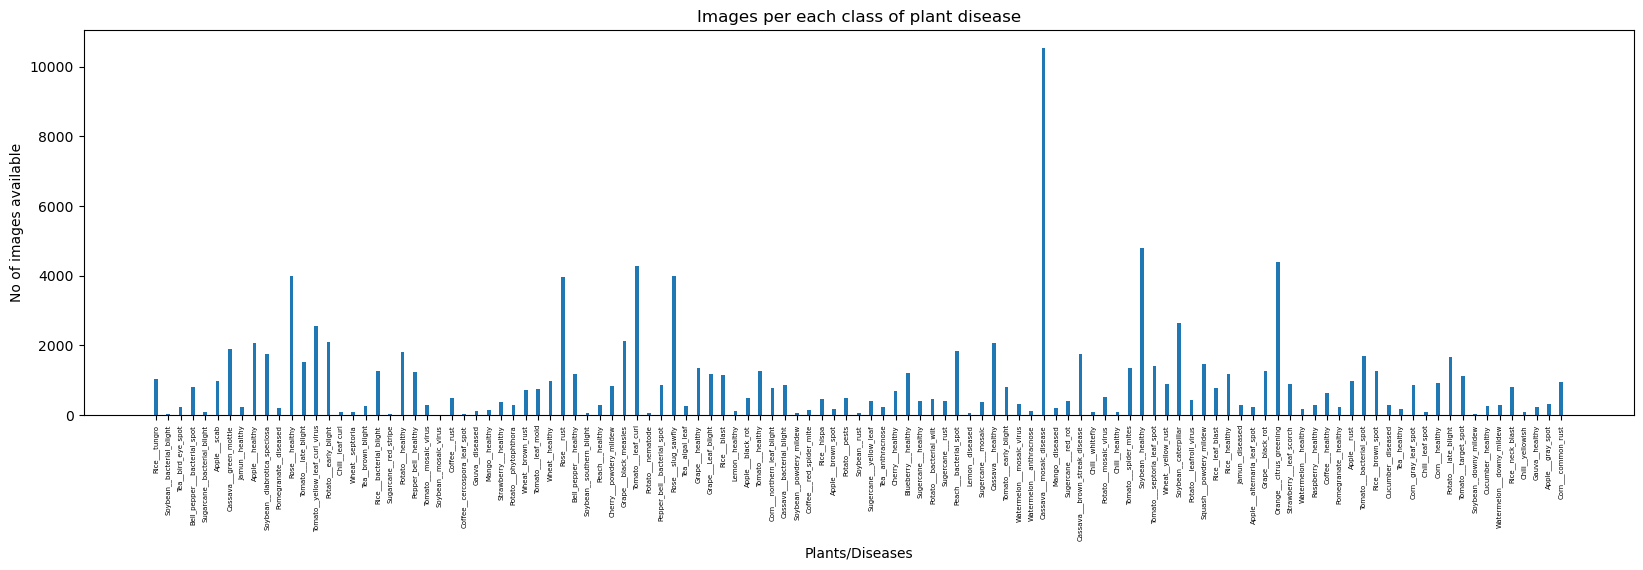

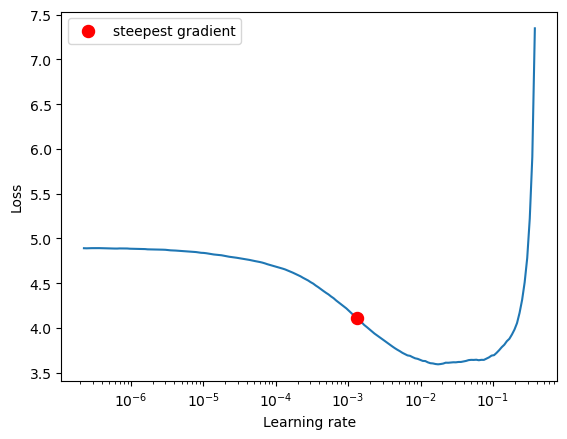


LR Finder suggests a learning rate of: 1.74e-03 for the virtual batch size.


In [24]:
from torch_lr_finder import LRFinder
import numpy as np

print(f"\n--- Finding Optimal LR for a batch size of {BATCH_SIZE_PHASE1} ---")

finder_model = SOTA_CustomCNN(SOTA_ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES).to(device)
temp_optimizer = optim.AdamW(finder_model.parameters(), lr=1e-7, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

lr_finder = LRFinder(finder_model, temp_optimizer, criterion, device=device)

# ✨ Pass the accumulation_steps to the finder ✨
lr_finder.range_test(
    dataloaders_phase1['train'], 
    end_lr=1, 
    num_iter=200, 
    accumulation_steps=accumulation_steps # <-- The key addition
)

# The rest of the logic remains the same
losses = np.array(lr_finder.history["loss"])
lrs = np.array(lr_finder.history["lr"])
min_loss_idx = np.argmin(losses)
suggested_lr_phase1 = lrs[min_loss_idx] / 10

lr_finder.plot()
lr_finder.reset()

print(f"\nLR Finder suggests a learning rate of: {suggested_lr_phase1:.2e} for the virtual batch size.")

In [25]:
LEARNING_RATE_PHASE1 = suggested_lr_phase1


# OneCycleLR is excellent for training from scratch
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE_PHASE1, weight_decay=1e-4)
scheduler = optim.lr_scheduler.OneCycleLR(optimizer, 
                                          max_lr=LEARNING_RATE_PHASE1, 
                                          epochs=NUM_EPOCHS_PHASE1, 
                                          steps_per_epoch=len(dataloaders_phase1['train']))

print(f"Phase 1 configured with AdamW, OneCycleLR, and an optimal max_lr of {LEARNING_RATE_PHASE1:.2e}")


Phase 1 configured with AdamW, OneCycleLR, and an optimal max_lr of 1.74e-03


In [26]:
LOAD_CHECKPOINT = True


In [27]:
# ===================================================================
# THE DEFINITIVE, PRODUCTION-READY train_model FUNCTION
# ===================================================================

def train_model(model, criterion, optimizer, scheduler, 
                dataloaders, dataset_sizes, checkpoint_path, log_path,
                num_epochs=25, start_epoch=0, 
                early_stopping_patience=5, load_optimizer_state=False):
    
    since = time.time()
    best_model_wts = model.state_dict()
    best_acc = 0.0
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lrs': []}

    writer = SummaryWriter(f'runs/{MODEL_NAME}')
    scaler = torch.amp.GradScaler('cuda', enabled=(device.type == 'cuda'))

    # --- Robust Checkpoint Loading ---
    if os.path.exists(checkpoint_path):
        print(f"Checkpoint found at {checkpoint_path}. Loading...")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        
        # ✨ THE FIX: Intelligently handle compiled vs. uncompiled models ✨
        # Get the actual model to load into (unwrap if compiled)
        model_to_load = model._orig_mod if torch.compile.is_compiled_module(model) else model
        model_to_load.load_state_dict(checkpoint['model_state_dict'])
        
        best_acc = checkpoint.get('accuracy', 0.0)
        print(f"Loaded best accuracy from previous run: {best_acc:.4f}")
        
        if load_optimizer_state:
            print("Loading optimizer and scheduler state to resume training...")
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
            start_epoch = checkpoint.get('epoch', 0) + 1
            print(f"Resuming training from Epoch {start_epoch}")
        else:
            print("Starting a new training stage. Optimizer and scheduler are NOT loaded from checkpoint.")

    # --- Main Training Loop ---
    for epoch in range(start_epoch, num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}'); print('-' * 10)

        # ======================== 1. TRAINING PHASE ========================
        model.train()
        running_loss, running_corrects = 0.0, 0
        
        optimizer.zero_grad()
        for inputs, labels in tqdm(dataloaders['train'], desc="Train Phase"):
            inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            
            with torch.set_grad_enabled(True):
                with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                scaler.scale(loss).backward()
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                if not isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    scheduler.step()
            
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_train_loss = running_loss / dataset_sizes['train']
        epoch_train_acc = (running_corrects.double() / dataset_sizes['train']).item()
        
        history['train_loss'].append(epoch_train_loss)
        history['train_acc'].append(epoch_train_acc)
        writer.add_scalar('Loss/train', epoch_train_loss, epoch)
        writer.add_scalar('Accuracy/train', epoch_train_acc, epoch)
        print(f'Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f}')

        # ======================== 2. VALIDATION PHASE ========================
        model.eval()
        running_loss, running_corrects = 0.0, 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(dataloaders['val'], desc="Validation Phase"):
                inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
                with torch.amp.autocast('cuda', enabled=(device.type == 'cuda')):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        epoch_val_loss = running_loss / dataset_sizes['val']
        epoch_val_acc = (running_corrects.double() / dataset_sizes['val']).item()

        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        writer.add_scalar('Loss/val', epoch_val_loss, epoch)
        writer.add_scalar('Accuracy/val', epoch_val_acc, epoch)
        current_lr = optimizer.param_groups[0]['lr']
        history['lrs'].append(current_lr)
        writer.add_scalar('Learning_Rate', current_lr, epoch)
        print(f'Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}')

        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(epoch_val_loss)

        # ======================== 3. END-OF-EPOCH TASKS ========================
        
        # --- CSV Logging ---
        # ✨ FIX: Ensure log directory exists before writing ✨
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        new_log_data = {
            'epoch': [epoch + 1], 'train_loss': [epoch_train_loss], 'train_acc': [epoch_train_acc],
            'val_loss': [epoch_val_loss], 'val_acc': [epoch_val_acc], 'lr': [current_lr]
        }
        new_log_df = pd.DataFrame(new_log_data)
        if not os.path.exists(log_path):
            new_log_df.to_csv(log_path, index=False)
        else:
            new_log_df.to_csv(log_path, mode='a', header=False, index=False)
        print(f"Epoch {epoch+1} results logged to {log_path}")

        # --- Early Stopping & Checkpointing ---
        if epoch_val_acc > best_acc:
            best_acc = epoch_val_acc
            epochs_no_improve = 0
            model_to_save = model._orig_mod if torch.compile.is_compiled_module(model) else model
            best_model_wts = model_to_save.state_dict()
            
            os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)
            torch.save({'epoch': epoch, 'model_state_dict': best_model_wts, 'optimizer_state_dict': optimizer.state_dict(),
                        'scheduler_state_dict': scheduler.state_dict(), 'loss': epoch_val_loss, 'accuracy': best_acc}, checkpoint_path)
            print(f"New best model saved to {checkpoint_path} with accuracy: {best_acc:.4f}")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= early_stopping_patience:
                print(f"Early stopping triggered after {epochs_no_improve} epochs with no improvement.")
                model.load_state_dict(best_model_wts)
                writer.close()
                return model, history
        
        print()
    final_model_to_load = model._orig_mod if torch.compile.is_compiled_module(model) else model
    final_model_to_load.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
    # --- End of Training ---
    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')
    model.load_state_dict(best_model_wts)
    writer.close()
    return model, history

In [28]:
print("--- Maximum Performance Configuration ---")
print(f"Phase 1: Training on {IMAGE_SIZE_PHASE1}x{IMAGE_SIZE_PHASE1} images with batch size {BATCH_SIZE_PHASE1}")
print(f"Phase 2: Fine-tuning on {IMAGE_SIZE_PHASE2}x{IMAGE_SIZE_PHASE2} images with batch size {BATCH_SIZE_PHASE2}")
print(f"Using {NUM_WORKERS} workers for data loading.")

--- Maximum Performance Configuration ---
Phase 1: Training on 192x192 images with batch size 192
Phase 2: Fine-tuning on 256x256 images with batch size 96
Using 8 workers for data loading.


LR suggestion: steepest gradient
Suggested LR: 1.30E-03


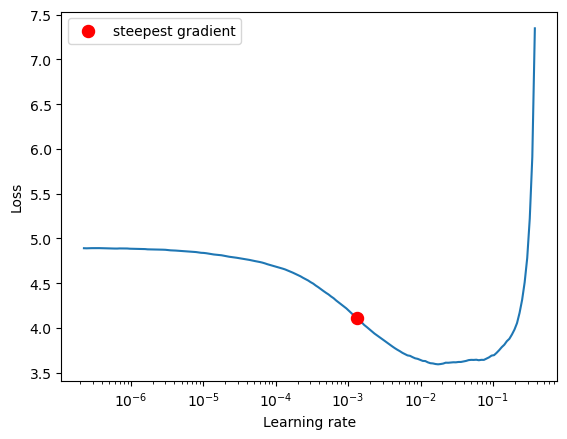

LR Finder plot saved to ./results/SOTA_CustomCNN/lr_finder_phase1.png


In [29]:
checkpoint_path_phase1 = os.path.join(CHECKPOINT_DIR, 'best_model_phase1.pth')
plot_lr_finder_save(lr_finder, os.path.join(RESULTS_DIR, "lr_finder_phase1.png"))
log_path_phase1 = os.path.join(RESULTS_DIR, 'training_log_phase1.csv')

In [30]:
model, history1 = train_model(model, criterion, optimizer, scheduler,
                              dataloaders=dataloaders_phase1,
                              dataset_sizes=dataset_sizes_phase1,
                              checkpoint_path=checkpoint_path_phase1,
                              log_path=log_path_phase1,
                              num_epochs=NUM_EPOCHS_PHASE1)

Epoch 1/20
----------


Train Phase: 100%|██████████| 591/591 [31:03<00:00,  3.15s/it]


Train Loss: 3.4390 Acc: 0.2581


Validation Phase: 100%|██████████| 74/74 [01:58<00:00,  1.60s/it]


Val Loss: 2.2320 Acc: 0.5256
Epoch 1 results logged to ./results/SOTA_CustomCNN/training_log_phase1.csv


AttributeError: 'function' object has no attribute 'is_compiled_module'

In [ ]:
print(f"\n--- PHASE 2: Starting Setup for Fine-tuning on {IMAGE_SIZE_PHASE2} x {IMAGE_SIZE_PHASE2} Images ---")



print(f"Using batch size of {BATCH_SIZE_PHASE2} for full-resolution training.")

data_transforms_phase2 = {
    'train': transforms.Compose([
        # For fine-tuning, we use the full resolution
        transforms.RandomResizedCrop(IMAGE_SIZE_PHASE2, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMAGE_SIZE_PHASE2 + 32),
        transforms.CenterCrop(IMAGE_SIZE_PHASE2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create the datasets and dataloaders for this phase
image_datasets_phase2 = {x: datasets.ImageFolder(os.path.join(DATA_DIR, x), data_transforms_phase2[x]) for x in ['train', 'val']}
dataloaders_phase2 = {x: DataLoader(image_datasets_phase2[x], batch_size=BATCH_SIZE_PHASE2, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True) for x in ['train', 'val']}
dataset_sizes_phase2 = {x: len(image_datasets_phase2[x]) for x in ['train', 'val']}

In [ ]:
print("\n--- Finding Optimal LR for Fine-Tuning ---")

finder_model_phase2 = SOTA_CustomCNN(SOTA_ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES, sd_probs=sd_probs).to(device)

# 2. Load the checkpoint from the compiled Phase 1 model
checkpoint_path_phase1 = os.path.join(CHECKPOINT_DIR, 'best_model_phase1.pth')
# We still need weights_only=False because of the NumPy scalar issue
checkpoint = torch.load(checkpoint_path_phase1, weights_only=False)
compiled_state_dict = checkpoint['model_state_dict']

# ✨ THE FIX: Clean the keys in the state_dict ✨
# Create a new dictionary and remove the '_orig_mod.' prefix from each key.
clean_state_dict = {}
for k, v in compiled_state_dict.items():
    # The key in the compiled model is '_orig_mod.layer1...', we want 'layer1...'
    if k.startswith('_orig_mod.'):
        new_key = k[len('_orig_mod.'):]
        clean_state_dict[new_key] = v
    else:
        # If for some reason a key doesn't have the prefix, keep it as is
        clean_state_dict[k] = v

# 3. Load the CLEANED state_dict into the fresh, uncompiled model
finder_model_phase2.load_state_dict(clean_state_dict)
print(f"LR Finder model loaded with cleaned weights from Phase 1.")
# Set up the finder
temp_optimizer = optim.AdamW(finder_model_phase2.parameters(), lr=1e-7, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
lr_finder = LRFinder(finder_model_phase2, temp_optimizer, criterion, device=device)

# Run the test on the new, high-resolution data
lr_finder.range_test(dataloaders_phase2['train'], end_lr=1, num_iter=200)

# Capture the suggestion automatically using the compatible method
losses = np.array(lr_finder.history["loss"])
lrs = np.array(lr_finder.history["lr"])
min_loss_idx = np.argmin(losses)
suggested_lr_phase2 = lrs[min_loss_idx] / 10

# Plot the results and clean up
lr_finder.plot()
lr_finder.reset()

print(f"\nLR Finder suggests a fine-tuning learning rate of: {suggested_lr_phase2:.2e}")
print("This value will now be used to configure the final training phase.")

In [ ]:
LEARNING_RATE_PHASE2 = suggested_lr_phase2

optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE_PHASE2, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=3)

print(f"Phase 2 configured with AdamW (LR={LEARNING_RATE_PHASE2:.2e}) and ReduceLROnPlateau scheduler.")


plot_lr_finder_save(lr_finder, os.path.join(RESULTS_DIR, "lr_finder_phase2.png"))
checkpoint_path_phase2 = os.path.join(CHECKPOINT_DIR, 'best_model_final.pth')
log_path_phase2 = os.path.join(RESULTS_DIR, 'training_log_phase2.csv')

In [ ]:
model, history2 = train_model(model, criterion, optimizer, scheduler,
                              dataloaders=dataloaders_phase2,
                              dataset_sizes=dataset_sizes_phase2,
                              checkpoint_path=checkpoint_path_phase2,
                              log_path=log_path_phase2,
                              num_epochs=NUM_EPOCHS_PHASE2,
                              load_optimizer_state=False)

In [ ]:
def plot_combined_history(history1, history2, model_name, save_path):
    """
    Combines and plots the training histories from two separate phases.
    """
    # Combine the metrics from both history objects
    full_history = {
        'train_acc': history1['train_acc'] + history2['train_acc'],
        'val_acc': history1['val_acc'] + history2['val_acc'],
        'train_loss': history1['train_loss'] + history2['train_loss'],
        'val_loss': history1['val_loss'] + history2['val_loss'],
        'lrs': history1.get('lrs', []) + history2.get('lrs', [])
    }
    
    num_epochs_phase1 = len(history1['train_acc'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    fig.suptitle(f'Combined Training History for {model_name}', fontsize=18)

    # --- Accuracy Plot ---
    ax1.plot(full_history['train_acc'], label='Train Acc', marker='.', linestyle='-')
    ax1.plot(full_history['val_acc'], label='Val Acc', marker='.', linestyle='-')
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Add a vertical line to show the transition between phases
    ax1.axvline(x=num_epochs_phase1 - 1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
    
    # Annotate the best validation accuracy
    best_val_acc = max(full_history['val_acc'])
    best_epoch = np.argmax(full_history['val_acc'])
    ax1.annotate(f'Best Val Acc: {best_val_acc:.4f}\nEpoch {best_epoch+1}',
                 xy=(best_epoch, best_val_acc),
                 xytext=(best_epoch, best_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center', fontsize=10)
    ax1.legend()

    # --- Loss Plot ---
    ax2.plot(full_history['train_loss'], label='Train Loss', marker='.', linestyle='-')
    ax2.plot(full_history['val_loss'], label='Val Loss', marker='.', linestyle='-')
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.axvline(x=num_epochs_phase1 - 1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
   

    # --- Learning Rate Plot ---
    if full_history['lrs']:
        plt.figure(figsize=(15, 5))
        plt.plot(full_history['lrs'])
        plt.title('Learning Rate Schedule (per batch)', fontsize=14)
        plt.xlabel('Batch # (cumulative)')
        plt.ylabel('Learning Rate')
        plt.grid(True, linestyle='--', alpha=0.6)
        # Add a vertical line for the phase transition
        num_batches_phase1 = len(history1.get('lrs', []))
        plt.axvline(x=num_batches_phase1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
        plt.legend()
        plt.show()


def plot_learning_rate_schedule(history):
    lrs = history.get('lrs', [])
    if len(lrs) > 0:
        plt.figure(figsize=(12,4))
        plt.plot(lrs)
        plt.title('Learning Rate (per batch)')
        plt.xlabel('Batch # (cumulative)')
        plt.ylabel('LR')
        plt.grid(alpha=0.3)
        plt.show()
    else:
        print('No LR data to plot.')

# --- Evaluation helpers ---
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

def evaluate_model(model, dataloader, class_names, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc='Eval'):
            inputs = inputs.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    return all_labels, all_preds


def plot_confusion_matrix(labels, preds, class_names, normalize=True, max_classes_display=50):
    cm = confusion_matrix(labels, preds)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
    # If too many classes, show a subset heatmap legend only
    if len(class_names) > max_classes_display:
        print(f"Too many classes ({len(class_names)}). Showing aggregated stats.")
        avg_diag = np.nanmean(np.diag(cm))
        print(f"Mean per-class accuracy: {avg_diag:.4f}")
        return
    plt.figure(figsize=(min(1+0.3*len(class_names), 25), min(1+0.3*len(class_names), 25)))
    sns.heatmap(cm, cmap='viridis', xticklabels=class_names, yticklabels=class_names, fmt='.2f' if normalize else 'd')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()


def show_misclassified(model, dataloader, class_names, device, n=12):
    model.eval()
    images = []
    labels_true = []
    labels_pred = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            mismatch = preds != labels.to(device)
            if mismatch.any():
                for i in torch.where(mismatch)[0]:
                    images.append(inputs[i].cpu())
                    labels_true.append(labels[i].item())
                    labels_pred.append(preds[i].item())
                    if len(images) >= n:
                        break
            if len(images) >= n:
                break
    if len(images) == 0:
        print('No misclassifications found in this subset.')
        return
    # Denormalize for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    cols = 4
    rows = int(np.ceil(len(images)/cols))
    plt.figure(figsize=(cols*4, rows*4))
    for idx, img in enumerate(images):
        img_dn = img*std + mean
        img_np = np.clip(img_dn.permute(1,2,0).numpy(), 0, 1)
        ax = plt.subplot(rows, cols, idx+1)
        ax.imshow(img_np)
        ax.axis('off')
        ax.set_title(f"T: {class_names[labels_true[idx]][:15]}\nP: {class_names[labels_pred[idx]][:15]}", fontsize=9)
    plt.suptitle('Sample Misclassified Images', fontsize=16)
    plt.tight_layout()
    plt.show()

# --- Grad-CAM (lightweight) ---
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        target_layer.register_forward_hook(self.forward_hook)
        target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, inp, out):
        self.activations = out.detach()

    def backward_hook(self, module, grad_in, grad_out):
        self.gradients = grad_out[0].detach()

    def generate(self, input_tensor, class_idx=None):
        self.model.zero_grad()
        output = self.model(input_tensor)
        if class_idx is None:
            class_idx = output.argmax(dim=1)
        selected = output[0, class_idx]
        selected.backward(retain_graph=True)
        weights = self.gradients.mean(dim=[2,3], keepdim=True)
        cam = (weights * self.activations).sum(dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = torch.nn.functional.interpolate(cam, size=input_tensor.shape[2:], mode='bilinear', align_corners=False)
        cam_min, cam_max = cam.min(), cam.max()
        cam = (cam - cam_min)/(cam_max - cam_min + 1e-8)
        return cam[0,0].cpu().numpy()


def plot_combined_history_save(history1, history2, model_name, save_path):
    """
    Combines and plots the training histories from two separate phases.
    """
    # Combine the metrics from both history objects
    full_history = {
        'train_acc': history1['train_acc'] + history2['train_acc'],
        'val_acc': history1['val_acc'] + history2['val_acc'],
        'train_loss': history1['train_loss'] + history2['train_loss'],
        'val_loss': history1['val_loss'] + history2['val_loss'],
        'lrs': history1.get('lrs', []) + history2.get('lrs', [])
    }
    
    num_epochs_phase1 = len(history1['train_acc'])

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 8))
    fig.suptitle(f'Combined Training History for {model_name}', fontsize=18)

    # --- Accuracy Plot ---
    ax1.plot(full_history['train_acc'], label='Train Acc', marker='.', linestyle='-')
    ax1.plot(full_history['val_acc'], label='Val Acc', marker='.', linestyle='-')
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Add a vertical line to show the transition between phases
    ax1.axvline(x=num_epochs_phase1 - 1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
    
    # Annotate the best validation accuracy
    best_val_acc = max(full_history['val_acc'])
    best_epoch = np.argmax(full_history['val_acc'])
    ax1.annotate(f'Best Val Acc: {best_val_acc:.4f}\nEpoch {best_epoch+1}',
                 xy=(best_epoch, best_val_acc),
                 xytext=(best_epoch, best_val_acc - 0.1),
                 arrowprops=dict(facecolor='black', shrink=0.05),
                 ha='center', fontsize=10)
    ax1.legend()

    # --- Loss Plot ---
    ax2.plot(full_history['train_loss'], label='Train Loss', marker='.', linestyle='-')
    ax2.plot(full_history['val_loss'], label='Val Loss', marker='.', linestyle='-')
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.axvline(x=num_epochs_phase1 - 1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
    ax2.legend()

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
   

    # --- Learning Rate Plot ---
    if full_history['lrs']:
        plt.figure(figsize=(15, 5))
        plt.plot(full_history['lrs'])
        plt.title('Learning Rate Schedule (per batch)', fontsize=14)
        plt.xlabel('Batch # (cumulative)')
        plt.ylabel('Learning Rate')
        plt.grid(True, linestyle='--', alpha=0.6)
        # Add a vertical line for the phase transition
        num_batches_phase1 = len(history1.get('lrs', []))
        plt.axvline(x=num_batches_phase1, color='grey', linestyle='--', linewidth=2, label='Phase 1/2 Transition')
        plt.legend()
        plt.show()
    
    plt.savefig(save_path, bbox_inches='tight')
    print(f"Combined history plot saved to {save_path}")
    plt.close() 


    
def visualize_gradcam(model, dataloader, class_names, device, n=3):
    # Pick the last residual layer for Grad-CAM
    target_layer = model.layer4[-1].bn2
    gradcam = GradCAM(model, target_layer)

    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)

    shown = 0
    for inputs, labels in dataloader:
        for i in range(inputs.size(0)):
            if shown >= n:
                return
            inp = inputs[i:i+1].to(device)
            cam = gradcam.generate(inp)
            img = (inputs[i]*std + mean).permute(1,2,0).numpy()
            img = np.clip(img, 0, 1)
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.imshow(cam, cmap='jet', alpha=0.4)
            pred_class = class_names[model(inp).argmax(1).item()]
            plt.title(f"True: {class_names[labels[i]]}\nPred: {pred_class}")
            plt.axis('off')
            plt.show()
            shown += 1

print("Visualization & evaluation helpers ready.")

In [ ]:
# ===================================================================
# ✨ CALLING THE NEW PLOTTING AND EVALUATION CODE ✨
# ===================================================================

# --- 1. Generate the Combined Training Plots ---
print("\n--- Generating Combined Training Plots ---")
# Use the new function with both history objects
plot_combined_history(history1, history2, "SOTA_CustomCNN")
plot_combined_history_save(history1, history2, MODEL_NAME, os.path.join(RESULTS_DIR, "training_history.png"))

# --- 2. Final Evaluation on the Unseen Test Set ---
print("\n--- FINAL EVALUATION: Running on the unseen test set ---")

import json
with open('class_names.json', 'r') as f:
    class_names = json.load(f)
print(f"Successfully loaded {len(class_names)} class names for evaluation.")

# B. Define the specific transforms for the test set (must match Phase 2 validation)
test_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE_PHASE2 + 32),
    transforms.CenterCrop(IMAGE_SIZE_PHASE2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# C. Create the test dataset and dataloader from scratch
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), test_transforms)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE_PHASE2, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
print(f"Test dataloader created with {len(test_dataset)} images.")

# D. Instantiate the correct, final model architecture
final_model = SOTA_CustomCNN(SOTA_ResidualBlock, [2, 2, 2, 2], num_classes=NUM_CLASSES, sd_probs=sd_probs)

# E. Compile the model for a speed boost if not on Windows
if int(torch.__version__.split('.')[0]) >= 2 and platform.system() != "Windows":
    try:
        final_model = torch.compile(final_model)
        print("Final evaluation model compiled successfully.")
    except Exception as e:
        print(f"Could not compile the final model: {e}")
final_model.to(device)

# F. Load the single best model saved from the ENTIRE process
final_checkpoint_path = os.path.join(CHECKPOINT_DIR, 'best_model_final.pth')
print(f"Loading best model for final evaluation from: {final_checkpoint_path}")
checkpoint = torch.load(final_checkpoint_path, map_location=device)
final_model.load_state_dict(checkpoint['model_state_dict'])

In [ ]:
# G. Evaluate the model on the newly created test dataloader
test_labels, test_preds = evaluate_model(final_model, test_dataloader, class_names, device)

# H. Print final reports
print("\n--- Final Test Set Classification Report ---")
print(classification_report(test_labels, test_preds, target_names=class_names, digits=4))

print("\n--- Final Test Set Confusion Matrix ---")
plot_confusion_matrix(test_labels, test_preds, class_names)

print("\n--- Sample Misclassified Images from Test Set ---")
show_misclassified(final_model, test_dataloader, class_names, device)

# --- 3. Grad-CAM Visualization on the Final Model ---
print("\n--- Grad-CAM Visualizations ---")
# This target layer is confirmed to be correct for the SOTA_CustomCNN architecture.
target_layer = final_model.layer4[-1].bn2 
visualize_gradcam(final_model, test_dataloader, class_names, device, target_layer=target_layer, n=5)